# Imports

In [14]:
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader

from transformers import AutoTokenizer, AdamW, DataCollatorWithPadding

from datasets import Dataset, DatasetDict, load_metric
import evaluate
import plotly.express as px
from tqdm.auto import tqdm


import os
import sys

current_path = os.getcwd()
parent_path = os.path.dirname(os.path.dirname(current_path))
sys.path.append(parent_path)

from helpers import ClassifierModel, loadTrainTweets, loadModel, normalizeTweets, tokenizeTweets


# Load Tweets

In [18]:
positive_file_path = os.path.join(parent_path,'data/train_pos_full.txt')
negative_file_path = os.path.join(parent_path,'data/train_neg_full.txt')
positive_file_path_small = os.path.join(parent_path,'data/train_pos.txt')
negative_file_path_small = os.path.join(parent_path,'data/train_neg.txt')


# Load  (Full and Small datasets)
df = loadTrainTweets(positive_file_path, negative_file_path)
df_small = loadTrainTweets(positive_file_path_small, negative_file_path_small)

## Learning Rate Hyperparameter Search

In [ ]:
checkpoint = 'vinai/bertweet-base'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_classfier = ClassifierModel(checkpoint = checkpoint, num_labels =2).to(device)
mode = 'train'

# Normalize Tweets
df = normalizeTweets(df)

# Tokenize Tweets
train_dataloader, eval_dataloader, test_dataloader = tokenizeTweets(checkpoint,df,mode)

metric = load_metric("accuracy")
Accs = []

# Define the range of logarithmic learning rates you want to search
log_learning_rate_range = [1e-7,1e-6,1e-5,1e-4,1e-3]

for learning_rate in log_learning_rate_range:
    model_classfier = ClassifierModel(checkpoint = checkpoint, num_labels =2).to(device)

    optimizer = AdamW(model_classfier.parameters(), lr=learning_rate)
    num_epochs = 6
    num_training_steps = num_epochs * len(train_dataloader)


    t = str(time.time())[:10]

    progress_bar_train = tqdm(range(num_training_steps))
    progress_bar_eval = tqdm(range(num_epochs * len(eval_dataloader)))

    Acc_max = 0

    for epoch in range(num_epochs):

        model_classfier.train()
        for batch in train_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            _, pure_loss = model_classfier(**batch)

            pure_loss.backward()

            optimizer.step()
            optimizer.zero_grad()
            progress_bar_train.update(1)

        model_classfier.eval()
        for batch in eval_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            with torch.no_grad():
                outputs, pure_loss = model_classfier(**batch)

            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1)
            metric.add_batch(predictions=predictions, references=batch['labels'])
            progress_bar_eval.update(1)
        Acc = metric.compute()

        if Acc > Acc_max:
            Acc_max = Acc

        print(f"Learning Rate: {learning_rate}, Acc: {Acc}")
    Accs.append(Acc_max)
    print('-------------------------------')


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


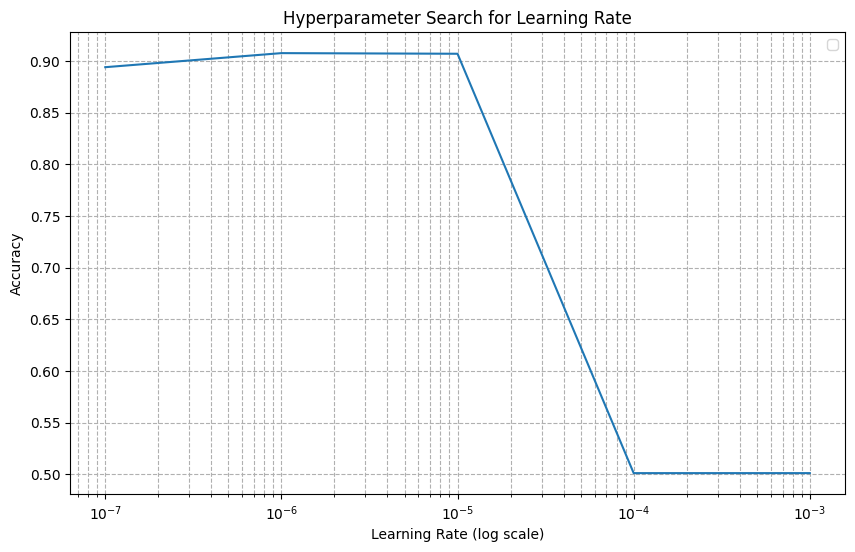

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(log_learning_rate_range,Accs)
plt.xscale('log')
plt.xlabel('Learning Rate (log scale)')
plt.ylabel('Accuracy')
plt.title('Hyperparameter Search for Learning Rate')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()

## Attention Map

### Load Model

In [3]:
checkpoint = 'vinai/bertweet-base'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Path of weights of 3 Best models
weights_1_file_path = 'weights/best_model_weights_1.pt'
weights_2_file_path = 'weights/best_model_weights_2.pt'
weights_3_file_path = 'weights/best_model_weights_3.pt'

model_classfier_1, model_classfier_2, model_classfier_3 = loadModel(checkpoint,device,\
                                                                    weights_1_file_path,weights_2_file_path,\
                                                                        weights_3_file_path)

## Plot Attention Map

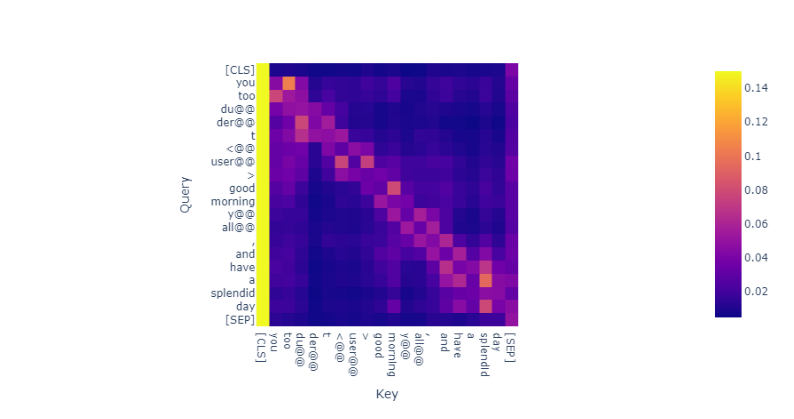

In [1]:
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
tokenizer.model_max_len=128


tweet = 'you too dudert <user> good morning yall, and have a splendid day'

# Tokenize Tweet
tokenized_tweet = tokenizer(tweet, truncation=True, max_length=128, return_tensors="pt",return_token_type_ids=False)
tokenized_tweetken = tokenized_tweet.to(device)

# Convert token IDs back to words
decoded_tokens = tokenizer.convert_ids_to_tokens(tokenized_tweet['input_ids'][0].tolist(),skip_special_tokens = False )

# Replace <s> by [CLS]
decoded_tokens = ['[CLS]' if token == '<s>' else token for token in decoded_tokens]

# Replace </s> by [SEP]
decoded_tokens = ['[SEP]' if token == '</s>' else token for token in decoded_tokens]


# Use First Best Model to plot Attention Map
# with torch.no_grad():
outputs, pure_loss = model_classfier_1(**tokenized_tweet)
attention = outputs.attentions

# # Plot Mean Attention
mean_attention = torch.stack(attention).mean(dim=0).cpu().detach().numpy().mean(axis=0).mean(axis=0)
mean_attention_clipped = np.clip(mean_attention,0,0.15)



# Plot attention
fig_attention = px.imshow(mean_attention_clipped,labels=dict(x="Key", y="Query"))

# Add xticks and yticks
fig_attention.update_xaxes(tickvals=list(range(len(decoded_tokens))), ticktext=decoded_tokens, title_text="Key")
fig_attention.update_yaxes(tickvals=list(range(len(decoded_tokens))), ticktext=decoded_tokens, title_text="Query")

fig_attention.show()

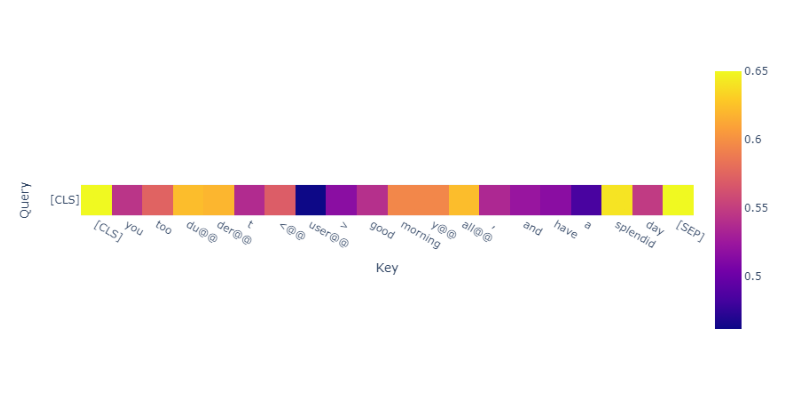

In [2]:
mean_attention = torch.stack(attention).mean(dim=0).cpu().detach().numpy().mean(axis=0).mean(axis=0)
mean_attention_clipped = np.clip(mean_attention,0,0.65)

# Plot attention
fig_attention = px.imshow(mean_attention_clipped[:,0].reshape(len(mean_attention_clipped),1).T)#,labels=dict(x="Key", y="Query"))

# Add xticks and yticks
fig_attention.update_xaxes(tickvals=list(range(len(decoded_tokens))), ticktext=decoded_tokens, title_text="Key")
fig_attention.update_yaxes(tickvals=list(range(len(decoded_tokens[0]))), ticktext=[decoded_tokens[0]], title_text="Query")

fig_attention.show()

## PCA of [CLS] token outputs

### Preprocess Tweets

In [55]:
df_sample = df.sample(frac=0.01).reset_index(drop=True)
df_normalized = normalizeTweets(df_sample)


dataset_ = Dataset.from_pandas(df_normalized)

dataset_hf = DatasetDict({
    'test': dataset_})

dataset_hf;


tokenizer = AutoTokenizer.from_pretrained(checkpoint)
tokenizer.model_max_len=128
def tokenize(batch):
    return tokenizer(batch["tweets"], truncation=True, max_length=128)
tokenized_dataset = dataset_hf.map(tokenize, batched=True)

tokenized_dataset.set_format('torch', columns=["input_ids", "labels"] )

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

test_dataloader = DataLoader(tokenized_dataset['test'], shuffle =False, batch_size = 16, collate_fn = data_collator)


Map: 100%|██████████| 25000/25000 [00:07<00:00, 3376.94 examples/s]


### Extract [CLS] output

In [56]:
class DataPoint:
    def __init__(self, cls_token, real_label, predicted_label,word_list):
        self.cls_token = cls_token
        self.real_label = real_label
        self.predicted_label = predicted_label

model_classfier_1.eval()


# Create a list to store instances of DataPoint
data_points = []

for batch in test_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}

    with torch.no_grad():
        outputs, pure_loss = model_classfier_1(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)

    real_labels = batch['labels']

    # Iterate over each sequence in the batch
    for i in range(len(predictions)):
        # Extract the CLS token representation
        hidden_states = outputs.hidden_states
        last_layer_hidden_states = hidden_states[-1]
        cls_token = last_layer_hidden_states[i, 0, :]
        word_list = tokenizer.convert_ids_to_tokens(batch['input_ids'][i].tolist())

        # Create an instance of DataPoint and store the information
        data_point = DataPoint(
            cls_token=cls_token,
            real_label=real_labels[i].item(),
            predicted_label=predictions[i].item(),
            word_list=word_list,
        )

        # Append the instance to the list
        data_points.append(data_point)


### Perform PCA

In [57]:
cls_tokens = [data_point.cls_token.cpu().numpy() for data_point in data_points]
real_labels = [data_point.predicted_label for data_point in data_points]

# Mapping dictionary for converting predictions to string labels
label_mapping = {
    0: 'Negative',
    1: 'Positive'
}

# Convert real labels to string labels for legend
legend_labels = [label_mapping[label] for label in set(real_labels)]

# Concatenate the CLS tokens into a single numpy array
cls_tokens_array = np.vstack(cls_tokens)

# Perform PCA to reduce to 2 dimensions
pca = PCA(n_components=3)
pca_result = pca.fit_transform(cls_tokens_array)


### Plot

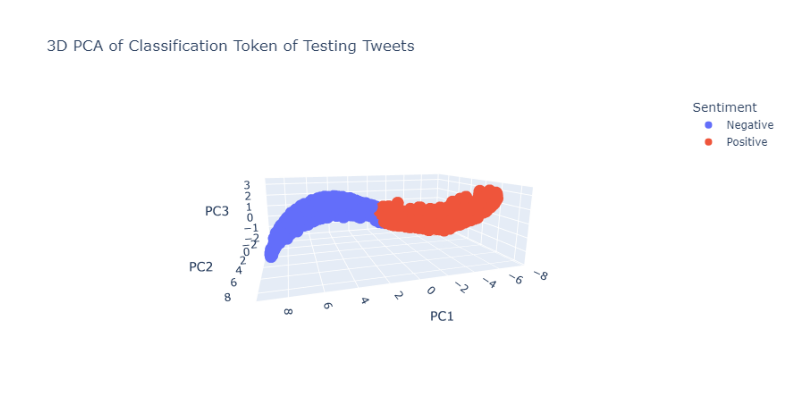

In [1]:
# Create a DataFrame for the 3D scatter plot
df_plot = pd.DataFrame({
    'PC1': pca_result[:, 0],
    'PC2': pca_result[:, 1],
    'PC3': pca_result[:, 2],
    'Real Label': [label_mapping[label] for label in real_labels]
})

# Create 3D scatter plot using Plotly
fig = px.scatter_3d(
    df_plot,
    x='PC1',
    y='PC2',
    z='PC3',
    color='Real Label',
    labels={'Real Label': 'Sentiment'},
    title='3D PCA of Classification Token of Testing Tweets'
)

# Show the plot
fig.show()
